# CS 598 Project Draft

### Saturday, April 6 2024

### Colton Bailey, Caleb Thomas, Indranil Ghosh
<hr>

## Introduction

The original paper titled "Detecting Heart Disease from Multi-View Ultrasound Images via Supervised Attention Multiple Instance Learning" by Huang et al. introduces an innovative approach to detecting heart disease using ultrasound images.

The authors addressed the difficulties of detecting heart disease though ultrasound images, why heart disease is a widespread issue throughout the world, and how early detection is necessary for more effective treatment and prognoses.

## Scope of Reproducibility

The scope of reproducibility for this [study](https://arxiv.org/abs/2306.00003) requires multiple steps, including:

### Data access

Accessing the [TMED2 dataset](https://tmed.cs.tufts.edu/tmed_v2.html) from the original authors is the foremost important step in an attempt to reproduce the work previously done. Having access to the same dataset ensures consistency in the model's performance while training and evaluation.

### Python virtual environment

Establishing the correct Python virtual interpreter and environment were also necessary to ensure all the required packages were installed and present.

For this project, the Python `3.11.5` interpreter was chosen and found the most success out of the box.

Missing dependencies can be installed with `pip` or `conda`.

In [ ]:
!python -V
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 --index https://download.pytorch.org/whl/ --upgrade-strategy only-if-needed
#!pip install pandas==2.2.1 pillow==10.2.0 scikit-learn==1.4.1.post1 scipy==1.13.0 tqdm==4.66.2 --upgrade-strategy only-if-needed

### Addressing platform compatibility

For users on Apple's M1/M2 chipsets, Apple Silicon, additional steps are needed to train the model locally due to the ARM instruction set. This involves writing additional code [TODO ADD CODE SNIPPET FROM MY BRANCH HERE TO SHOW CHANGES NEEDED] to target the onboard GPUs that is not CUDA. Fortunately, Apple and PyTorch provide a new package named Metal to [accelerate PyTorch training on Mac](https://developer.apple.com/metal/pytorch/).

Due to this some additional requirements are needed to be met:
- Mac computers with Apple silicon or AMD GPUs
- macOS 12.3 or later
- Python 3.7 or later

### Adapting code

Additional debugging may be needed, primarily due to differences in package versions, as well as the dataset changing format from `.npy` to `.png`.

### Initiating training

Once completed with the previous steps (if applicable), initiating the training process using the [codebase](https://github.com/tufts-ml/SAMIL) and TMED2 dataset is the next step. This involves running the training pipeline to train the model on the dataset of labeled and unlabeled ultrasound images.

## Methodology

### Data

#### Data descriptions

**Source of the data**: The Tufts Medical Echocardiogram Dataset TMED-2 (Huang et al., 2022), is a collection of 2D echocardiogram images gathered during routine care at Tufts Medical Center in Boston, MA, USA from 2016-2021.

**Statistics**:
view_and_diagnosis_labeled_set : 599 studies from 577 unique patients (some patients have multiple studies on distinct days).
The patients are partitioned into "splits" of 360 training, 119 validation, and 120 test studies.

**view_labeled_set** : 705 studies from 703 unique patients

**unlabeled_set** : 5486 studies from 5287 patients

The data is stored in two top-level directory:

1) labels : stored in comma-separated-value (CSV) plain-text files

2) images : stored within folders as 112x112 pixel grayscale PNG files

Labels and assignments of the labeled set to different train/validation/test splits are stored in the following CSV files in the top-level directory. Each CSV file has a row for each image file in the dataset, providing the relevant labels. The CSV file specs are as followed -

1) labels_per_image.csv : CSV file with one row per image.

- query_key
Filename of specific image, as a string. Example: "2977s1_0.png".

- view_label
View label, as a string. Options: {"PLAX", "PSAX", "A4C", "A2C", "A4CorA2CorOther"}

- diagnosis_label
Diagnostic severity label, as a string. Options: {"no_as", "mild_as", "mildtomoderate_AS", "moderate_AS", "severe_AS", "Not_Provided"}

2) TMED2_foldX_labeledpart.csv : CSV file with one row per image. Integer X denotes the specific train/valid/test split, and could take values in {0, 1, 2}

- query_key
Filename of specific image, as a string. Example: "2977s1_0.png".

- view_classifier_split
String that indicates which standard data split for image-level view classifier this image belongs to within fold X. Options: {"train", "val", "test"}.

- diagnosis_classifier_split
String that indicates which standard data split for image-level diagnosis classifier this image belongs to within fold X. Options: {"train", "val", "test", "not_used"}.

- view_label
View label, as a string. Options: {"PLAX", "PSAX", "A4C", "A2C", "A4CorA2CorOther"}

- diagnosis_label
Diagnostic severity label, as a string. Options: {"no_as", "mild_as", "mildtomoderate_AS", "moderate_AS", "severe_AS", "Not_Provided"}

- SourceFolder
Diagnostic severity label, as a string. Options: {"no_as", "mild_as", "mildtomoderate_AS", "moderate_AS", "severe_AS", "Not_Provided"}

3) TMED2_foldX_unlabeledpart.csv : CSV file with one row per image. Integer X denotes the specific train/valid/test split, and could take values in {0, 1, 2} (these splits correspond exactly to the 3 splits used in our paper's experiments).

- query_key
Filename of specific image, as a string. Example: "2977s1_0.png".

- SourceFolder
Folder that the image is located


The Images are stored within a hierarchy of folders such as below:

view_and_diagnosis_labeled_set/labeled/
view_and_diagnosis_labeled_set/unlabeled/
view_labeled_set/labeled/
view_labeled_set/unlabeled/
unlabeled_set/unlabeled/

#### Implementation Code

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

import os
from tqdm import tqdm
from dataclasses import dataclass

from google.colab import drive

## Accessing the Dataset
1. Open the Google Drive link: https://drive.google.com/drive/folders/1n31WeVVK7qU7k1pF1WIDRxT-bMJjGubK?usp=drive_link with a @illinois.edu account.

2. Right click the **SAMIL_colab_data_1** folder, in the options select Organize/Add Shortcut, and then add the shortcut to **MyDrive**.

In [3]:
drive.mount('/content/drive')
%cd "/content/drive/.shortcut-targets-by-id/1n31WeVVK7qU7k1pF1WIDRxT-bMJjGubK/SAMIL_colab_data_1"
!ls

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1n31WeVVK7qU7k1pF1WIDRxT-bMJjGubK/SAMIL_colab_data_1
checkpoint  data  info	results  src


In [4]:
from src.dataset import EchoDataset
import src.models as models
import src.utils as utils

@dataclass()
class TrainingArgs():
    patience=200
    batch_size=1
    num_workers=2
    dataset_name='echo'
    training_seed=0
    development_size='DEV479'
    train_epoch=10
    start_epoch=0
    eval_every_Xepoch=1
    script="src.SAMIL.main"
    use_data_normalization=False
    augmentation='RandAug'
    sampling_strategy='first_frame'
    use_class_weights=True
    class_weights = [0.25, 0.25, 0.25]
    Pretrained='Whole'
    ViewRegularization_warmup_schedule_type='Linear'
    ViewRegularization_warmup_pos = 0.4
    optimizer_type='SGD'
    nesterov = "store_true"
    lr_schedule_type='CosineLR'
    lr_warmup_epochs = 0
    lr_cycle_epochs=5

    ema_decay = 0.999

    checkpoint_dir = "checkpoint"
    data_info_dir = "info"
    data_dir = "data"

    assert torch.cuda.is_available(), "Need GPU"
    device = torch.device("cuda")

    data_seed = 0
    train_dir = f"training"
    train_PatientStudy_list_path = f"{data_info_dir}/train_studies.csv"
    val_PatientStudy_list_path = f"{data_info_dir}/val_studies.csv"
    test_PatientStudy_list_path = f"{data_info_dir}/test_studies.csv"

    resume='last_checkpoint.pth.tar'
    resume_checkpoint_fullpath = f"{checkpoint_dir}/{resume}"

    lr=0.0005
    wd=0.0001
    lambda_ViewRegularization=20
    T=0.05

args = TrainingArgs()
utils.set_seed(args.training_seed)

transform_eval = transforms.Compose([
    transforms.ToTensor()
])
transform_labeledtrain = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(
        size=112, padding=int(112*0.125), padding_mode='reflect'
        ),
    utils.RandAugmentMC(n=2, m=10),
    transforms.ToTensor()
])

train_PatientStudy_list = pd.read_csv(args.train_PatientStudy_list_path)
train_PatientStudy_list = train_PatientStudy_list['study'].values
val_PatientStudy_list = pd.read_csv(args.val_PatientStudy_list_path)
val_PatientStudy_list = val_PatientStudy_list['study'].values
test_PatientStudy_list = pd.read_csv(args.test_PatientStudy_list_path)
test_PatientStudy_list = test_PatientStudy_list['study'].values

TMED2SummaryTable = pd.read_csv(os.path.join(args.data_info_dir, 'TMED2SummaryTable.csv'))

train_dataset = EchoDataset(
    train_PatientStudy_list,
    TMED2SummaryTable,
    args.data_dir,
    sampling_strategy=args.sampling_strategy,
    training_seed=args.training_seed,
    transform_fn=transform_labeledtrain
    )
val_dataset = EchoDataset(
    val_PatientStudy_list,
    TMED2SummaryTable,
    args.data_dir,
    sampling_strategy='first_frame',
    training_seed=args.training_seed,
    transform_fn=transform_eval
    )
test_dataset = EchoDataset(
    test_PatientStudy_list,
    TMED2SummaryTable,
    args.data_dir,
    sampling_strategy='first_frame',
    training_seed=args.training_seed,
    transform_fn=transform_eval
    )

train_loader = DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers
    )
val_loader = DataLoader(
    val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers
    )
test_loader = DataLoader(
    test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers
    )

Processing [4] studies
Processing [4] studies
Processing [4] studies


### Model

#### Model descriptions

The authors have used Supervised Attention Multiple Instance Learning (SAMIL) model. This framework integrates multiple views of ultrasound images to detect heart disease. In Multiple Instance Learning (MIL) framework, instead of labeling individual images, only a set of (bags) of instances are labeled. Here, a set or a bag represents a whole ultrasound image, and the model learns to make predictions based on the presence or absence of heart disease in each image.

From a set of images of unknown and diverse views, a feature extractor processes each image individually into an embedding vector. On these, two attention modules are applied - 1)one supervised by a view classifier, and 2) one without. These modules produce attention weights for each instance. The final study representation averages the image embeddings by combining the two attentions.

Through the SAMIL framework, the model learns to distinguish between positive instances with heart disease and negative instances without heart disease.

#### Implementation code

In [5]:
class SAMIL(nn.Module):
    def __init__(self, num_classes=3):
        super(SAMIL, self).__init__()
        self.L = 500
        self.B = 250
        self.D = 128
        self.K = 1
        self.num_classes = num_classes
        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
             #hz added
            nn.Conv2d(50, 100, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(100, 200, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )
        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(200 * 4 * 4, self.L),
            nn.ReLU(),
        )
        self.feature_extractor_part3 = nn.Sequential(

            nn.Linear(self.L, self.B),
            nn.ReLU(),
            nn.Linear(self.B, self.L),
            nn.ReLU(),
        )
        self.attention_V = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )
        self.attention_U = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )
        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, self.num_classes),
        )

    def forward(self, x):
        x = x.squeeze(0)
        H = self.feature_extractor_part1(x)
        H = H.view(-1, 200 * 4 * 4)
        H = self.feature_extractor_part2(H)  # NxL
        A_V = self.attention_V(H)  # NxK
        A_V = torch.transpose(A_V, 1, 0)  # KxN
        A_V = F.softmax(A_V, dim=1)  # softmax over N
        H = self.feature_extractor_part3(H)
        A_U = self.attention_U(H)  # NxK
        A_U = torch.transpose(A_U, 1, 0)
        A_U = F.softmax(A_U, dim=1)
        A = torch.exp(torch.log(A_V) + torch.log(A_U))
        A = A/torch.sum(A)
        M = torch.mm(A, H)
        out = self.classifier(M)
        return out, A_V


weights = args.class_weights
weights = torch.Tensor(weights)
weights = weights.to(args.device)

print("Sending to:", args.device)

view_model = models.create_view_model(args)
view_model.to(args.device)

model = SAMIL()
model.to(args.device)

no_decay = ['bias', 'bn']
grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(
        nd in n for nd in no_decay)], 'weight_decay': args.wd},
    {'params': [p for n, p in model.named_parameters() if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = optim.SGD(
    grouped_parameters, lr=args.lr, momentum=0.9, nesterov=args.nesterov
    )
scheduler = utils.get_cosine_schedule_with_warmup(
    optimizer, args.lr_warmup_epochs, args.lr_cycle_epochs
    )
ema_model = models.ModelEMA(args, model, args.ema_decay)
args.start_epoch = 0

assert os.path.isfile(args.resume_checkpoint_fullpath)

if not torch.cuda.is_available():
    checkpoint = torch.load(
        args.resume_checkpoint_fullpath, map_location=torch.device('cpu')
        )
else:
    checkpoint = torch.load(args.resume_checkpoint_fullpath)

model.load_state_dict(checkpoint['state_dict'])
ema_model.ema.load_state_dict(checkpoint['ema_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

Sending to: cuda
self.param_keys: ['feature_extractor_part1.0.weight', 'feature_extractor_part1.0.bias', 'feature_extractor_part1.3.weight', 'feature_extractor_part1.3.bias', 'feature_extractor_part1.6.weight', 'feature_extractor_part1.6.bias', 'feature_extractor_part1.9.weight', 'feature_extractor_part1.9.bias', 'feature_extractor_part2.0.weight', 'feature_extractor_part2.0.bias', 'feature_extractor_part3.0.weight', 'feature_extractor_part3.0.bias', 'feature_extractor_part3.2.weight', 'feature_extractor_part3.2.bias', 'attention_V.0.weight', 'attention_V.0.bias', 'attention_V.2.weight', 'attention_V.2.bias', 'attention_U.0.weight', 'attention_U.0.bias', 'attention_U.2.weight', 'attention_U.2.bias', 'classifier.0.weight', 'classifier.0.bias']
self.buffer_keys: []


### Training

Our best model was trained for 594 epochs, and used the following during training:
1. Stochastic Gradient Descent was used for the optimizer.
2. The loss is a combination of minimizing the Cross-Entropy loss between the observed diagnosis labels and the predicted probabilities for a bag of training images.The second part of the loss is minimizing the KL-divergence between the
relevance scores (given by the view classifier) and the attention weights. The final piece of the loss equation is the hyperparameter, Lambda View Regularization. It determines the weight that is given to the KL-divergence term.
3. At the end of each epoch the model is evaluated using a validation set. This validation set serves two purposes. The first is that it allows Early Stopping to be used. If the validation balance accuracy hasn't peaked in a set number of epochs the model's training is stopped. Secondly, it allows for checkpoints of the model to be saved when a new peak validation balance accuracy is reached.

#### Computational requirements

The total training time to train the model for 594 epochs was ~14 hours. So a hardware configuration similar to the following setup is recommended:

1. CPU: 13th Gen Intel(R) Core(TM) i7-13700K, 16 cores, 5400 MHz base clock speed, offering substantial parallel processing capabilities suitable for deep learning tasks.
2. RAM: 32 GB of RAM, providing sufficient memory for loading large batches of data during training and reducing data transfer overhead.
3. GPU: NVIDIA RTX 4070 Super Ti with 16 GB of VRAM, offering powerful computational capabilities for accelerating deep learning computations, particularly matrix multiplications and convolutions commonly found in CNNs.

#### Implementation code

In [6]:
def train_one_epoch(
        args, weights, train_loader, model, ema_model, view_model, optimizer, scheduler, epoch
        ):
    model.train()
    TotalLoss_this_epoch = []
    LabeledCELoss_this_epoch = []
    ViewRegularizationLoss_this_epoch = []
    scaled_ViewRegularizationLoss_this_epoch = []
    train_iter = iter(train_loader)
    print("\nNumber of Train Studies: ", len(train_loader))
    n_steps_per_epoch = len(train_loader) #360 train studies, batch size 1
    p_bar = tqdm(range(n_steps_per_epoch), disable=False)
    for batch_idx in range(n_steps_per_epoch):
        try:
            data, bag_label = train_iter.next()
        except:
            train_iter = iter(train_loader)
            data, bag_label = train_iter.next()
        data, bag_label = data.to(args.device), bag_label.to(args.device)
        outputs, attentions = model(data)
        log_attentions = torch.log(attentions)
        with torch.no_grad():
            view_predictions = view_model(data.squeeze(0))
            softmax_view_predictions = F.softmax(view_predictions, dim=1)
            predicted_relevance = softmax_view_predictions[:, :2]
            predicted_relevance = torch.sum(predicted_relevance, dim=1)
            predicted_relative_relevance = F.softmax(predicted_relevance/args.T)
            predicted_relative_relevance = predicted_relative_relevance.unsqueeze(0)
        if args.use_class_weights:
            LabeledCELoss = F.cross_entropy(outputs, bag_label, weights, reduction='mean')
        else:
            LabeledCELoss = F.cross_entropy(outputs, bag_label, reduction='mean')
        assert args.ViewRegularization_warmup_schedule_type == 'Linear'
        current_warmup = np.clip(
            epoch/(float(args.ViewRegularization_warmup_pos) * args.train_epoch), 0, 1
            )
        ViewRegularizationLoss = F.kl_div(
            input=log_attentions, target=predicted_relative_relevance, log_target=False, reduction='batchmean'
            )
        # backward pass
        total_loss = LabeledCELoss + args.lambda_ViewRegularization * ViewRegularizationLoss * current_warmup
        total_loss.backward()

        TotalLoss_this_epoch.append(total_loss.item())
        LabeledCELoss_this_epoch.append(LabeledCELoss.item())
        ViewRegularizationLoss_this_epoch.append(ViewRegularizationLoss.item())
        scaled_ViewRegularizationLoss_this_epoch.append(
            args.lambda_ViewRegularization * ViewRegularizationLoss.item() * current_warmup
            )
        optimizer.step()
        ema_model.update(model)
        model.zero_grad()
    scheduler.step()
    return (
        TotalLoss_this_epoch,
        LabeledCELoss_this_epoch,
        ViewRegularizationLoss_this_epoch,
        scaled_ViewRegularizationLoss_this_epoch
        )
epochs, should_train = 2, False
if should_train:
    args.start_epoch, args.train_epoch = 0, epochs
    train_loss_dict = dict()
    train_loss_dict['Totalloss'] = []
    train_loss_dict['LabeledCEloss'] = []
    train_loss_dict['ViewRegularizationLoss'] = []
    for epoch in tqdm(range(args.start_epoch, args.train_epoch)):
        TotalLoss_list,\
        LabeledCEloss_list,\
        ViewRegularizationLoss_list,\
        scaled_ViewRegularizationLoss_list\
        = train_one_epoch(
            args, weights, train_loader, model, ema_model, view_model, optimizer, scheduler, epoch
            )
        print(f"Trained Epoch: {epoch}")
        train_loss_dict['Totalloss'].extend(TotalLoss_list)
        train_loss_dict['LabeledCEloss'].extend(LabeledCEloss_list)
        train_loss_dict['ViewRegularizationLoss'].extend(ViewRegularizationLoss_list)


### Evaluation

#### Metrics descriptions

The authors use balance accuracy as their primary performance metric, and we do the same. The reason for this is because of the class imbalance in the TMED-2 dataset. Balance accuracy involves taking the sum of the true positives for each class divided by the total number of examples with that class.

#### Implementation code

In [ ]:
from sklearn.metrics import confusion_matrix as sklearn_cm

def calculate_balanced_accuracy(prediction, true_target, return_type = 'only balanced_accuracy'):
    soft = F.softmax(torch.Tensor(prediction), dim=1)
    confusion_matrix = sklearn_cm(true_target, torch.argmax(soft, dim=1).numpy())
    n_class = confusion_matrix.shape[0]
    assert n_class==3
    recalls = []
    for i in range(n_class):
        recall = confusion_matrix[i,i]/np.sum(confusion_matrix[i])
        recalls.append(recall)
        print('class{} recall: {}'.format(i, recall), flush=True)
    balanced_accuracy = np.mean(np.array(recalls))
    if return_type == 'all':
        return balanced_accuracy * 100, recalls
    return balanced_accuracy * 100

def eval_model(args, data_loader, raw_model, ema_model):
    raw_model.eval()
    ema_model.eval()
    data_loader = tqdm(data_loader, disable=False)
    with torch.no_grad():
        total_targets = []
        total_raw_outputs = []
        total_ema_outputs = []
        for batch_idx, (data, bag_label) in enumerate(data_loader):
            data, bag_label = data.to(args.device), bag_label.to(args.device)
            raw_outputs, raw_attention_weights = raw_model(data)
            ema_outputs, ema_attention_weights = ema_model(data)
            total_targets.append(bag_label.detach().cpu())
            total_raw_outputs.append(raw_outputs.detach().cpu())
            total_ema_outputs.append(ema_outputs.detach().cpu())

        total_targets = np.concatenate(total_targets, axis=0)
        total_raw_outputs = np.concatenate(total_raw_outputs, axis=0)
        total_ema_outputs = np.concatenate(total_ema_outputs, axis=0)
        raw_Bacc = calculate_balanced_accuracy(total_raw_outputs, total_targets)
        ema_Bacc = calculate_balanced_accuracy(total_ema_outputs, total_targets)

    return raw_Bacc, ema_Bacc, total_targets, total_raw_outputs, total_ema_outputs

val_score = eval_model(args, val_loader, model, ema_model.ema)
test_score = eval_model(args, test_loader, model, ema_model.ema)
print(f"Validation Raw Balance Acc Score: ", val_score[0])
print(f"Test Raw Balance Acc Score: ", test_score[0])


## Results

#### Results

Our best SAMIL model trained for a total of 594 epochs with the following hyperparameters:
1. Optimizer = SGD
2. Learning Rate = 0.0005
3. Weight Decay = 0.0001
4. T = 0.1
5. Lambda View Regularization = 20.0

The model demonstrated promising performance, achieving a test balance accuracy of 70.5%. While this result is sufficient for the scope of this project, it falls slightly short of the 75.4% accuracy reported in the original paper.

Analysis of the total loss over epochs reveals intriguing insights into the model's performance. Initially, from epoch 0 to around 300, there was a consistent decline in the total loss, indicating effective learning and convergence towards an optimal solution. However, beyond epoch 500, the total loss exhibited a trend of maintaining a higher threshold. This shift suggests potential overfitting of the dataset, where the model begins to memorize the training data rather than generalizing well to unseen examples.


#### Analyses

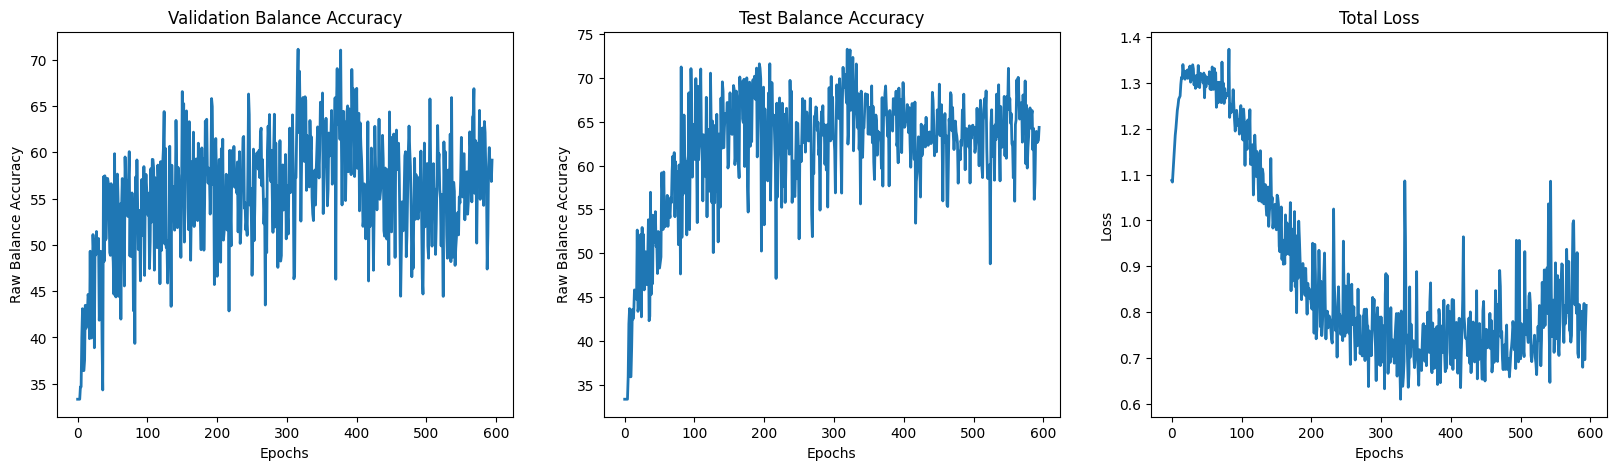

In [ ]:
val_raw_bacc_results = pd.read_csv("results/validation_bal_acc.csv")
test_raw_bacc_results = pd.read_csv("results/test_bal_acc.csv")
loss_results = pd.read_csv("results/loss.csv")

plt.figure(figsize=(20, 5))

ax = plt.subplot(1, 3, 1)
ax.set_title("Validation Balance Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Raw Balance Accuracy")
plt.plot(val_raw_bacc_results["Step"], val_raw_bacc_results["Value"], linewidth=2)

ax = plt.subplot(1, 3, 2)
ax.set_title("Test Balance Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Raw Balance Accuracy")
plt.plot(test_raw_bacc_results["Step"], test_raw_bacc_results["Value"], linewidth=2)


ax = plt.subplot(1, 3, 3)
ax.set_title("Total Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.plot(loss_results["Step"], loss_results["Value"], linewidth=2)

plt.show()

#### Plans

We plan to continue to tune the hyperparameters in an attempt to exceed the test balance accuracy acheived in the original paper.

As previously mentioned in the results subsection, the total loss increases after ~epoch 500. Updating hyperparameters such as learning rate or dropout could potentially help mitigate this overfitting. We plan to do this through hyperparameter search using grid search to find the best set of hyperparameters.

We also plan to introduce a more eager early stopping mechanism to prevent the model from overfitting the data. By monitoring the validation loss and stopping training when it increases over a period of time or by a certain amount, this will prevent from overfitting and lead to better performance on general datasets.

Finally, data augmentation is something we have considered to increase the size of the dataset. Data augmentation can be a simple change to the images in the dataset that will greatly expand the size and diversity of the images, thus improving performance. We plan to augment the data by rotating and flipping the ultrasound images in the dataset.